# **xwOBA Model**

# Part 1 - Data collection

In [29]:
from pybaseball import statcast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

For this project, I'll be using three years of data. This way it is recent, but is still measured **prior** to the 2023 rule changes.

In [30]:
three_year_data = statcast(start_dt="2020-07-23", end_dt="2022-11-05")

This is a large query, it may take a moment to complete


C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates
Skipping offseason dates


100%|████████████████████████████████████████████████████████████████████████████████| 579/579 [06:02<00:00,  1.60it/s]


Since I'm designing a process to find **xwOBAcon**, I'm only using balls in play.

In [31]:
contact_data = three_year_data[three_year_data['description'] == 'hit_into_play']
contact_data

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
193,SL,2022-11-05,89.2,-0.06,6.14,"Pressly, Ryan",592206,519151,field_out,hit_into_play,...,4,1,4,1,4,Standard,Standard,137,0.011,-0.219
196,FF,2022-11-05,93.9,-0.18,5.94,"Pressly, Ryan",547180,519151,field_out,hit_into_play,...,4,1,4,1,4,Infield shift,Standard,210,0.022,-0.3
208,FF,2022-11-05,93.0,-0.09,5.97,"Pressly, Ryan",592663,519151,single,hit_into_play,...,4,1,4,1,4,Standard,Standard,212,-0.02,0.262
216,SL,2022-11-05,88.1,-0.15,6.03,"Pressly, Ryan",656555,519151,field_out,hit_into_play,...,4,1,4,1,4,Infield shift,Standard,120,0.018,-0.158
139,KC,2022-11-05,86.4,-2.67,5.86,"Robertson, David",663656,502085,field_out,hit_into_play,...,1,1,4,4,1,Infield shift,Standard,47,-0.001,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,FF,2020-07-23,96.4,-1.94,5.56,"Cole, Gerrit",607208,543037,field_out,hit_into_play,...,2,2,0,0,2,Standard,Standard,225,-0.022,-0.414
254,FF,2020-07-23,95.9,-3.16,5.49,"Scherzer, Max",519317,453286,home_run,hit_into_play,...,0,2,0,2,0,Standard,Standard,222,-0.18,1.787
281,SL,2020-07-23,86.7,-3.27,5.32,"Scherzer, Max",650402,453286,field_out,hit_into_play,...,0,0,0,0,0,Infield shift,Standard,124,0.018,-0.335
330,FF,2020-07-23,96.7,-3.26,5.44,"Scherzer, Max",592450,453286,single,hit_into_play,...,0,0,0,0,0,Infield shift,Standard,220,-0.025,0.272


Preliminary scatter plot of exit velocity and launch angle, colored by type of ball in play.

In [32]:
contact_data = contact_data.dropna(subset = ['launch_angle', 'launch_speed'])

Text(0.5, 0, 'Exit Velocity (mph)')

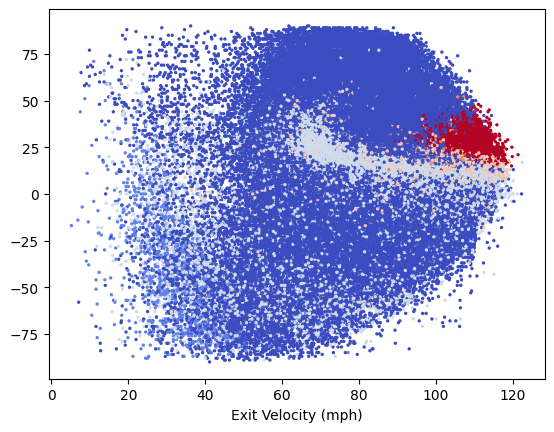

In [33]:
fig, ax = plt.subplots()
plt.scatter(x = contact_data['launch_speed'], y = contact_data['launch_angle'],
           c = contact_data['woba_value'], cmap = 'coolwarm', s = 2)
ax.set_xlabel('Exit Velocity (mph)')

To make it easier on our model, I am going to make every type of ball in play with a wOBA of 0 into "out." I also will be excluding catcher's interference because the swings were interfered with.

In [34]:
contact_data = contact_data.replace(['field_out', 'force_out', 'grounded_into_double_play', 
                                               'fielders_choice_out', 'sac_fly', 'field_error', 'sac_bunt_double_play',
                                              'fielders_choice', 'sac_bunt', 'double_play', 'triple_play',
                                              'sac_fly_double_play'], 'out')

In [35]:
contact_data.drop(contact_data[contact_data['events'] == 'catcher_interf'].index, inplace = True)

In [36]:
contact_data

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
193,SL,2022-11-05,89.2,-0.06,6.14,"Pressly, Ryan",592206,519151,out,hit_into_play,...,4,1,4,1,4,Standard,Standard,137,0.011,-0.219
196,FF,2022-11-05,93.9,-0.18,5.94,"Pressly, Ryan",547180,519151,out,hit_into_play,...,4,1,4,1,4,Infield shift,Standard,210,0.022,-0.3
208,FF,2022-11-05,93.0,-0.09,5.97,"Pressly, Ryan",592663,519151,single,hit_into_play,...,4,1,4,1,4,Standard,Standard,212,-0.02,0.262
216,SL,2022-11-05,88.1,-0.15,6.03,"Pressly, Ryan",656555,519151,out,hit_into_play,...,4,1,4,1,4,Infield shift,Standard,120,0.018,-0.158
139,KC,2022-11-05,86.4,-2.67,5.86,"Robertson, David",663656,502085,out,hit_into_play,...,1,1,4,4,1,Infield shift,Standard,47,-0.001,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,FF,2020-07-23,96.4,-1.94,5.56,"Cole, Gerrit",607208,543037,out,hit_into_play,...,2,2,0,0,2,Standard,Standard,225,-0.022,-0.414
254,FF,2020-07-23,95.9,-3.16,5.49,"Scherzer, Max",519317,453286,home_run,hit_into_play,...,0,2,0,2,0,Standard,Standard,222,-0.18,1.787
281,SL,2020-07-23,86.7,-3.27,5.32,"Scherzer, Max",650402,453286,out,hit_into_play,...,0,0,0,0,0,Infield shift,Standard,124,0.018,-0.335
330,FF,2020-07-23,96.7,-3.26,5.44,"Scherzer, Max",592450,453286,single,hit_into_play,...,0,0,0,0,0,Infield shift,Standard,220,-0.025,0.272


# Part 2 - Baseline model

Now that our data is set up, we can create our baseline model for xwOBAcon.

In [37]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

In [38]:
contact_data["events_encoded"] = [0 if x == "out" 
                                  else 1 if x == "single" 
                                  else 2 if x == "double" 
                                  else 3 if x == "triple" 
                                  else 4 for x in contact_data["events"]]

In [39]:
X = contact_data[["launch_speed", "launch_angle"]]
Y = contact_data[['events_encoded']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = .2)

We have to scale the results because exit velocity can be any positive number, while launch angle can only be between -90 and 90. This will give us a clearer, more accurate neighborhood.

In [40]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [41]:
classifier = KNeighborsClassifier(n_neighbors = 23, p = 2, metric = 'euclidean', )

In [42]:
classifier.fit(X_train, Y_train)

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(metric='euclidean', n_neighbors=23)

In [57]:
Y_pred = classifier.predict(X_test)

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [58]:
cm = confusion_matrix(Y_test, Y_pred)
print(cm)

[[37634  2500   406     0   407]
 [ 6095  6337   134     0    25]
 [ 1961  1126   522     0   235]
 [  159    87    26     0    46]
 [  800     1   143     0  1888]]


In [59]:
classifier.predict_proba(X_test)

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


array([[0.26086957, 0.65217391, 0.08695652, 0.        , 0.        ],
       [0.65217391, 0.34782609, 0.        , 0.        , 0.        ],
       [0.7826087 , 0.13043478, 0.04347826, 0.04347826, 0.        ],
       ...,
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.73913043, 0.26086957, 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ]])

In [60]:
print(accuracy_score(Y_test, Y_pred))

0.766222824291284


In [62]:
print(Y_test)

      events_encoded
1824               1
5238               0
1446               0
1410               0
407                0
...              ...
284                2
1193               0
961                0
775                0
3518               0

[60532 rows x 1 columns]


# Part 3 - Assessing the model

Here we will take a closer look at our model and evaluate it a little bit, starting with the log loss metric.

In [63]:
from sklearn.metrics import log_loss
Y_pred_proba = classifier.predict_proba(X_test)
log_loss(Y_test, Y_pred_proba)

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


1.1580183239994077

In [49]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split

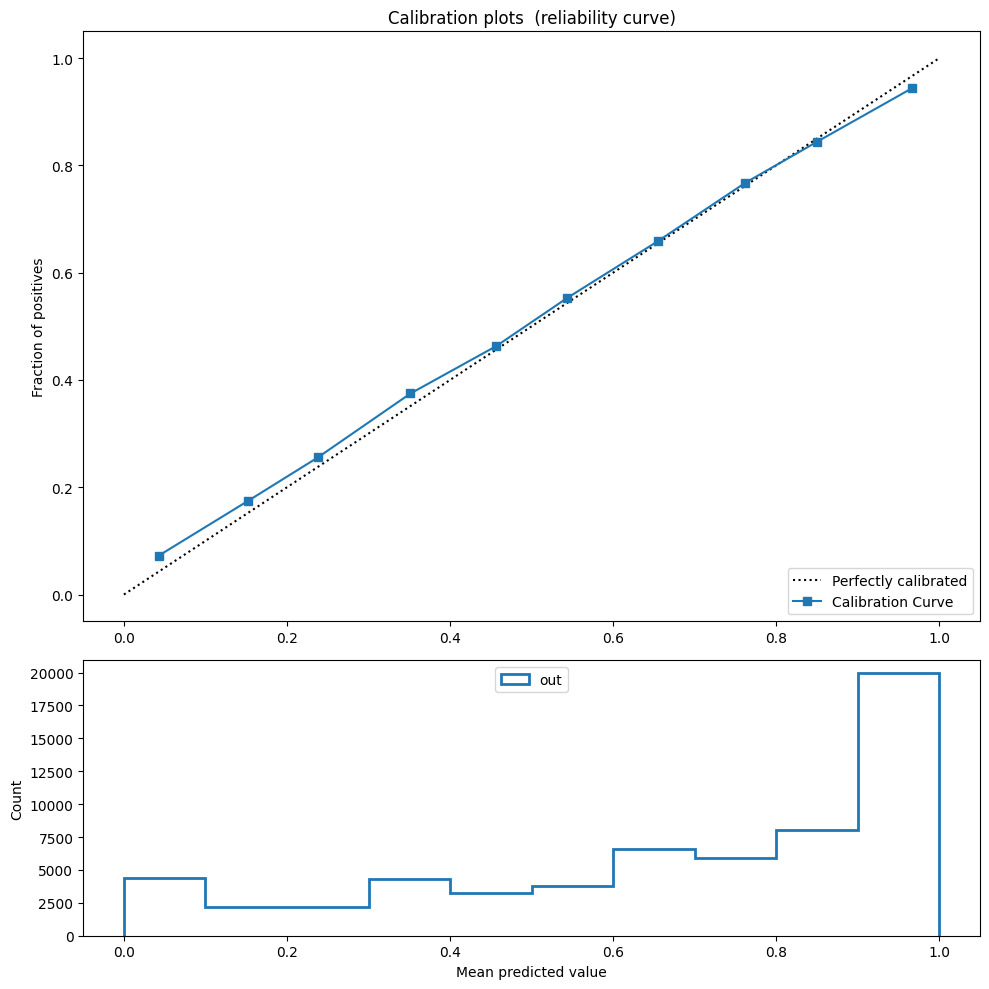

In [64]:
def plot_calibration_curve(outcome_type):
    """"Plot calibration curve for est w/o and with calibration.
    
    outcome_type: One of "out", "single", "double", "triple",
        or "home_run"
    """

    # Establish figure
    fig = plt.figure(0, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    # Map outcome to the original indices corresponding to
    # our target variable
    ind = 0 if outcome_type == "out" else \
        1 if outcome_type == "single" else \
        2 if outcome_type == "double" else \
        3 if outcome_type == "triple" else 4

    # Find the column in Y_pred_proba corresponding
    # to our output type
    prob_pos = Y_pred_proba[:, ind]

    # Create the binary output variable. 1 if the value
    # from Y_test equals ind (our outcome type) and 0 otherwise
    y_binary = [1 if x == ind else 0 for x in Y_test["events_encoded"]]

    # Plotting
    ## Plot a line of perfect calibration
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    # Construct the calibration curve
    fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_binary, prob_pos, n_bins=10)

    # Plot the calibration curve
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="Calibration Curve")

    # Plot a histogram showing the volume of plays
    ax2.hist(prob_pos, range=(0, 1), bins=10, label=outcome_type,
             histtype="step", lw=2)


    # Organize plots
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()


plot_calibration_curve("out")

In [54]:
X_test = pd.DataFrame(X_test, columns=["launch_speed", "launch_angle"])

In [55]:
pred_df = pd.DataFrame(classifier.predict_proba(X_test), columns=['out', 'single', 'double', 'triple', 'home_run'])
combined_df = pd.concat([X_test, pred_df], axis=1)
combined_df["output"] = list(Y_test["events_encoded"])

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [56]:
combined_df

,launch_speed,launch_angle,out,single,double,triple,home_run,output
0,0.863330,-0.078199,0.260870,0.652174,0.086957,0.000000,0.000000,1
1,-1.712929,-2.247223,0.652174,0.347826,0.000000,0.000000,0.000000,0
2,0.244229,-0.801207,0.782609,0.130435,0.043478,0.043478,0.000000,0
3,0.297485,0.885811,0.956522,0.000000,0.043478,0.000000,0.000000,0
4,0.477224,-0.732349,0.826087,0.130435,0.043478,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...
60527,0.723533,0.610380,0.391304,0.000000,0.086957,0.000000,0.521739,2
60528,-0.488041,1.953109,1.000000,0.000000,0.000000,0.000000,0.000000,0
60529,-0.022051,0.920240,1.000000,0.000000,0.000000,0.000000,0.000000,0
60530,-1.726243,-2.247223,0.739130,0.260870,0.000000,0.000000,0.000000,0
